# Generalizing mutagenesis pipeline

Allowing for facile input of a transcript id/other information to automate process.

In [1]:
import numpy as np
import gffutils
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd 
from pegg import prime
import Bio.Seq

In [2]:
#importing human reference genome
filepath = '/Users/samgould/Desktop/FSR Lab/reference files/GRCh38/ncbi-genomes-2022-02-23/GCF_000001405.26_GRCh38_genomic.fna.gz'
chrom_dict, i = prime.genome_loader(filepath)

In [3]:
#GRCh38 database
#loading in genome annotations
db = gffutils.FeatureDB('/Users/samgould/Desktop/FSR Lab/reference files/gencode_v44_GRCh38.db', keep_order=True)

#accessed genome annotations using gffutils package
#canonical MANE transcript for CDK9 (CDK9-201)
tx = 'ENST00000373264.5'


def tx_processor(tx):
    cds = list(db.children(tx, order_by='+end', featuretype=['CDS']))
    start_end_cds = [[i.start, i.end] for i in cds]
    strand = db[tx].strand
    chrom = db[tx].chrom
    #print(chrom[3:])
    #print(strand)
    #print(db[tx].attributes)

    #including 20 nt buffer on either side of exon for generating PAM sequences
    start_end_cds_20 = []
    buffer = 20
    for k in start_end_cds:
        h = []
        for idx, j in enumerate(k):
            if idx==0:
                h.append(j-buffer)
            if idx==1:
                h.append(j+buffer)
        start_end_cds_20.append(h)

    return start_end_cds_20, start_end_cds, chrom, strand

#tx_processor(tx)

In [4]:
def mutagenize(tx, chrom_dict):
    
    start_end_cds_20, start_end_cds, chrom, strand = tx_processor(tx)
    #chr9 = chrom_dict[9]
    chr9 = chrom_dict[int(chrom[3:])]

    plus_count = 0
    minus_count = 0

    plus_pam_loc_start = []
    plus_pam_loc_end = []
    PAM_plus = []
    plus_protospacer = []
    plus_proto_start = []
    plus_proto_end = []
    plus_ideal_start = []
    plus_ideal_end = []
    plus_ideal_window = []
    plus_exon_list = []

    minus_pam_loc_start = []
    minus_pam_loc_end = []
    PAM_minus = []
    minus_protospacer = []
    minus_proto_start = []
    minus_proto_end = []
    minus_ideal_start = []
    minus_ideal_end = []
    minus_ideal_window = []
    minus_exon_list = []

    #need to modify this to run it more generally!!!
    #COME BACK TO THIS
    #exon_list = [1,2,3,4,5,6,7]
    if strand=='+':
        exon_list = list(range(1, len(start_end_cds)+1))
    elif strand=='-':
        exon_list = list(range(1, len(start_end_cds)+1))[::-1]

    for idx1, i in enumerate(start_end_cds_20):
        s = i[0]-1
        e = i[1]

        sub_chrom=str(chr9[s:e]).upper()
        #print(sub_chrom)
        loc_list = list(range(s, e))

        for idx, k in enumerate(sub_chrom):
            #first deal with the plus strand
            if k=='G':
                
                if idx-20 >=0:
                    plus_count+=1
                    plus_pam_loc_start.append(loc_list[idx])
                    plus_pam_loc_end.append(loc_list[idx]+1)

                    PAM_plus.append(str(chr9[loc_list[idx]-1:loc_list[idx]+1]).upper())
                    
                    proto_start = loc_list[idx]-21
                    proto_end = loc_list[idx]-1
                    proto = str(chr9[proto_start: proto_end]).upper()
                    plus_protospacer.append(proto)
                    plus_proto_start.append(proto_start+1)
                    plus_proto_end.append(proto_end)

                    #and ideal editing window
                    plus_ideal_start.append(proto_start+3+1)
                    plus_ideal_end.append(proto_start+8)
                    plus_ideal_window.append(str(chr9[proto_start+3: proto_start+8]).upper())
                    plus_exon_list.append(exon_list[idx1])

            #then the minus strand
            if k=='C':

                if idx+20<=len(sub_chrom):
                    minus_count+=1

                    minus_pam_loc_end.append(loc_list[idx])
                    minus_pam_loc_start.append(loc_list[idx]+1)

                    PAM_minus.append(str(chr9[loc_list[idx]:loc_list[idx]+2].reverse_complement()).upper())

                    proto_end = loc_list[idx]+2
                    proto_start = loc_list[idx] + 22
                    proto = str(chr9[proto_end: proto_start].reverse_complement()).upper()

                    minus_protospacer.append(proto)
                    minus_proto_start.append(proto_start)
                    minus_proto_end.append(proto_end+1)

                    #and ideal editing window
                    minus_ideal_start.append(proto_start-3)
                    minus_ideal_end.append(proto_start-8+1)
                    minus_ideal_window.append(str(chr9[proto_start-8: proto_start-3].reverse_complement()).upper())
                    minus_exon_list.append(exon_list[idx1])

    col_names = ['protospacer', 'exon', 'proto_start', 'proto_end', 'PAM', 'PAM_start', 'PAM_end', 'ideal_start', 'ideal_end', 'ideal_window']

    cols = [plus_protospacer, plus_exon_list, plus_proto_start,plus_proto_end,PAM_plus,plus_pam_loc_start,plus_pam_loc_end, plus_ideal_start, plus_ideal_end, plus_ideal_window ]
    plus_df = pd.DataFrame(dict(zip(col_names, cols)))
    plus_df['strand'] = '+'


    cols_minus = [minus_protospacer, minus_exon_list, minus_proto_start,minus_proto_end,PAM_minus,minus_pam_loc_start,minus_pam_loc_end, minus_ideal_start, minus_ideal_end, minus_ideal_window ]

    minus_df = pd.DataFrame(dict(zip(col_names, cols_minus)))
    minus_df['strand'] = '-'
    

    #filter out guides whose ideal editing window doesn't hit in an exon
    cds_hit = []
    for i, val in plus_df.iterrows():
        ideal_start = val['ideal_start']
        ideal_end = val['ideal_end']-1
        
        hit=False
        for k in start_end_cds:
            exon_coords = list(range(k[0], k[1]+1))
            if ideal_start in exon_coords:
                hit=True
            if ideal_end in exon_coords:
                hit=True
            
        cds_hit.append(hit)

    plus_df['CDS_hit'] = cds_hit

    #and do the same for the minus strand
    #filter out guides whose ideal editing window doesn't hit in an exon
    cds_hit = []
    for i, val in minus_df.iterrows():
        ideal_start = val['ideal_start']-1
        ideal_end = val['ideal_end']
        
        hit=False
        for k in start_end_cds:
            exon_coords = list(range(k[0], k[1]+1))
            if ideal_start in exon_coords:
                hit=True
            if ideal_end in exon_coords:
                hit=True
            
        cds_hit.append(hit)

    minus_df['CDS_hit'] = cds_hit
    
    return pd.concat((plus_df, minus_df))

In [5]:
siglec_11_tx = 'ENST00000447370.6'

#from uniprot Q96RL6-1
siglec_11_protein ='MVPGQAQPQSPEMLLLPLLLPVLGAGSLNKDPSYSLQVQRQVPVPEGLCVIVSCNLSYPRDGWDESTAAYGYWFKGRTSPKTGAPVATNNQSREVEMSTRDRFQLTGDPGKGSCSLVIRDAQREDEAWYFFRVERGSRVRHSFLSNAFFLKVTALTKKPDVYIPETLEPGQPVTVICVFNWAFKKCPAPSFSWTGAALSPRRTRPSTSHFSVLSFTPSPQDHDTDLTCHVDFSRKGVSAQRTVRLRVAYAPKDLIISISHDNTSALELQGNVIYLEVQKGQFLRLLCAADSQPPATLSWVLQDRVLSSSHPWGPRTLGLELRGVRAGDSGRYTCRAENRLGSQQQALDLSVQYPPENLRVMVSQANRTVLENLGNGTSLPVLEGQSLRLVCVTHSSPPARLSWTRWGQTVGPSQPSDPGVLELPPIQMEHEGEFTCHAQHPLGSQHVSLSLSVHYPPQLLGPSCSWEAEGLHCSCSSQASPAPSLRWWLGEELLEGNSSQGSFEVTPSSAGPWANSSLSLHGGLSSGLRLRCKAWNVHGAQSGSVFQLLPGKLEHGGGLGLGAALGAGVAALLAFCSCLVVFRVKICRKEARKRAAAEQDVPSTLGPISQGHQHECSAGSSQDHPPPGAATYTPGKGEEQELHYASLSFQGLRLWEPADQEAPSTTEYSEIKIHTGQPLRGPGFGLQLEREMSGMVPK'

#making a table out of this
col_names = ['Gene', 'Transcript ID', 'Protein']
cols = [['Siglec-11'],[siglec_11_tx], [siglec_11_protein]]

siglec_11 = pd.DataFrame(dict(zip(col_names, cols)))
siglec_11

,Gene,Transcript ID,Protein
0,Siglec-11,ENST00000447370.6,MVPGQAQPQSPEMLLLPLLLPVLGAGSLNKDPSYSLQVQRQVPVPE...


# Simulated Mutagenesis 


In [7]:
wt_seq = 'KKGTACYW'
mut_seq = 'KGGTTCRW'

def hgvsp_simple(wt_seq, mut_seq):
    if wt_seq==mut_seq:
        return 'WT'
    else:
        pos_mutated = []

        for i in range(len(wt_seq)):
            if wt_seq[i] != mut_seq[i]:
                pos_mutated.append(i + 1)
        
        hg = ''
        for idx, pos in enumerate(pos_mutated):
            if idx==0:
                hg+= f'{wt_seq[pos-1]}{pos}{mut_seq[pos-1]}'
            else:
                hg+= f'_{wt_seq[pos-1]}{pos}{mut_seq[pos-1]}'
        

        return hg

hgvsp_simple(wt_seq, mut_seq)

'K2G_A5T_Y7R'

In [8]:
import itertools

def ABE_mutater(ideal_window):
    #count the As
    count_A = ideal_window.count('A')

    #generate all possible combinatoric mutation possibilities
    list_combs = []
    for i in range(1, count_A+1):

        list_combs+=list(itertools.combinations(range(count_A), i))

    #index the As
    l_key = []
    counter=0
    for i in ideal_window:
        if i=='A':
            l_key.append(counter)
            counter+=1
        else:
            l_key.append('None')

    #generate the mutated sequences
    mutated_ideal = []
    for i in list_combs:
        len_combination = len(i)

        mut_seq = ''
        #for k in i:
        for idx, base in enumerate(ideal_window):
            if l_key[idx] in i:
                mut_seq+='G'
            else:
                mut_seq+=base

        mutated_ideal.append(mut_seq)

    return mutated_ideal

def CBE_mutater(ideal_window):
    #count the As
    count_C = ideal_window.count('C')

    #generate all possible combinatoric mutation possibilities
    list_combs = []
    for i in range(1, count_C+1):

        list_combs+=list(itertools.combinations(range(count_C), i))

    #index the As
    l_key = []
    counter=0
    for i in ideal_window:
        if i=='C':
            l_key.append(counter)
            counter+=1
        else:
            l_key.append('None')

    #generate the mutated sequences
    mutated_ideal = []
    for i in list_combs:
        len_combination = len(i)

        mut_seq = ''
        #for k in i:
        for idx, base in enumerate(ideal_window):
            if l_key[idx] in i:
                mut_seq+='T'
            else:
                mut_seq+=base

        mutated_ideal.append(mut_seq)

    return mutated_ideal

In [9]:
def plus_mutate(plus_df):

    cds_plus = plus_df[plus_df['CDS_hit']==True]
    cds_plus = cds_plus.reset_index().drop(columns='index')


    cds_plus['gRNA_id'] = [f'gRNA_{i+1}' for i in range(len(cds_plus))]

    #perform combinatoric replacement
    #ABE: A>G
    #CBE: C>T
    ABE_amenable = []
    CBE_amenable = []

    ABE_edits = []
    ABE_edit_guides = []
    CBE_edits = []
    CBE_edit_guides = []

    for i, val in cds_plus.iterrows():
        ideal_window = val['ideal_window']
        gRNA = val['gRNA_id']

        #start with ABE:
        if 'A' in ideal_window:
            ABE_amenable.append(True)
            ABE_mutations = ABE_mutater(ideal_window)
            for k in ABE_mutations:
                ABE_edits.append(k)
                ABE_edit_guides.append(gRNA)

        else:
            ABE_amenable.append(False)

        if 'C' in ideal_window:
            CBE_amenable.append(True)
            CBE_mutations = CBE_mutater(ideal_window)
            for k in CBE_mutations:
                CBE_edits.append(k)
                CBE_edit_guides.append(gRNA)

        else:
            CBE_amenable.append(False)


    cds_plus['ABE_amenable'] = ABE_amenable
    cds_plus['CBE_amenable'] = CBE_amenable

    CBE_edits_df = pd.DataFrame(dict(zip(['gRNA_id', 'edit'], [CBE_edit_guides, CBE_edits])))
    ABE_edits_df = pd.DataFrame(dict(zip(['gRNA_id', 'edit'], [ABE_edit_guides, ABE_edits])))
    CBE_edits_df['Editor'] = 'CBE'
    ABE_edits_df['Editor'] = 'ABE'

    return cds_plus, CBE_edits_df, ABE_edits_df

def minus_mutate(minus_df, plus_df):
    cds_minus = minus_df[minus_df['CDS_hit']==True]
    cds_minus = cds_minus.reset_index().drop(columns='index')


    cds_minus['gRNA_id'] = [f'gRNA_{i+1}' for i in range(len(plus_df), len(plus_df)+len(cds_minus))]

    #perform combinatoric replacement
    #ABE: A>G
    #CBE: C>T
    ABE_amenable = []
    CBE_amenable = []

    ABE_edits = []
    ABE_edit_guides = []
    CBE_edits = []
    CBE_edit_guides = []

    for i, val in cds_minus.iterrows():
        ideal_window = val['ideal_window']
        gRNA = val['gRNA_id']

        #start with ABE:
        if 'A' in ideal_window:
            ABE_amenable.append(True)
            ABE_mutations = ABE_mutater(ideal_window)
            for k in ABE_mutations:
                ABE_edits.append(k)
                ABE_edit_guides.append(gRNA)

        else:
            ABE_amenable.append(False)

        if 'C' in ideal_window:
            CBE_amenable.append(True)
            CBE_mutations = CBE_mutater(ideal_window)
            for k in CBE_mutations:
                CBE_edits.append(k)
                CBE_edit_guides.append(gRNA)

        else:
            CBE_amenable.append(False)


    cds_minus['ABE_amenable'] = ABE_amenable
    cds_minus['CBE_amenable'] = CBE_amenable

    CBE_edits_df = pd.DataFrame(dict(zip(['gRNA_id', 'edit'], [CBE_edit_guides, CBE_edits])))
    ABE_edits_df = pd.DataFrame(dict(zip(['gRNA_id', 'edit'], [ABE_edit_guides, ABE_edits])))
    CBE_edits_df['Editor'] = 'CBE'
    ABE_edits_df['Editor'] = 'ABE'

    return cds_minus, CBE_edits_df, ABE_edits_df

In [10]:
def simulate_mutations_plus(input_df, WT_transcript_full, start_end_cds, strand, chrom_dict, chrom):

    chr9 = chrom_dict[int(chrom[3:])]

    hgvsp_holder = []
    potential_splice_holder = []

    wt_seq = str(Bio.Seq.Seq(WT_transcript_full).transcribe().translate())

    for i, val in input_df.iterrows():
        wt_ideal_seq = val['ideal_window']
        mut_ideal_seq = val['edit']
        ideal_start = val['ideal_start']
        ideal_end = val['ideal_end']

        mut_transcript = ''
        wt_transcript = ''

        potential_splice = False

        for i in start_end_cds:
            s = i[0]
            e = i[1]
   

            contained=False
            contained_fully = False
            contained_start = False
            contained_end = False

            if ((ideal_end <= e) and (ideal_end>=s) and (ideal_start <= e) and (ideal_start>=s)):
                contained=True
                contained_fully=True

            else:
                if ((ideal_start <= e) and (ideal_start>=s)):
                    contained=True
                    contained_start = True
                    potential_splice=True

                if ((ideal_end <= e) and (ideal_end>=s)):
                    contained=True
                    contained_end=True
                    potential_splice=True
                    
            if contained==False:
                mut_transcript+=chr9[s-1:e]
                wt_transcript+=chr9[s-1:e]
            
            elif contained==True:
                #NEED TO DEAL WITH EDGE CASES WHERE IDEAL EDITING WINDOW OVERLAPS WITH BEGINNING/END OF EXON
                #the first example (first set of parameters) has this precise issue...
                if contained_fully == True:
                    sub_tx_wt = chr9[s-1:ideal_start-1] + wt_ideal_seq + chr9[ideal_end:e]
                    sub_tx_mut = chr9[s-1:ideal_start-1] + mut_ideal_seq + chr9[ideal_end:e]
                    mut_transcript+=sub_tx_mut
                    wt_transcript +=sub_tx_wt

                elif contained_start==True:
                    #here the end needs to be cut off
                    
                    sub_tx_mut = chr9[s-1:ideal_start-1] + mut_ideal_seq[:e-ideal_end]
                    sub_tx_wt = chr9[s-1:ideal_start-1] + wt_ideal_seq[:e-ideal_end]
                    #print(val['gRNA_id'])
                    #print(chr9[s-1:ideal_start])
                    #print(wt_ideal_seq[:e-ideal_end-1])
                    mut_transcript+=sub_tx_mut
                    wt_transcript +=sub_tx_wt


                elif contained_end==True:
                    #here the start needs to be cut off
                    sub_tx_mut = mut_ideal_seq[s-ideal_start:] + chr9[ideal_end:e]
                    sub_tx_wt = wt_ideal_seq[s-ideal_start:] + chr9[ideal_end:e]
                    #print(sub_tx_wt)
                    mut_transcript+=sub_tx_mut
                    wt_transcript +=sub_tx_wt


        if strand=='+':
            #print(sub_tx_wt)
            #print(wt_transcript.upper() + '\n'+ WT_transcript_full.upper())
            
            assert wt_transcript.upper()==WT_transcript_full.upper() , f'non-matching WT transcript | {val["gRNA_id"]} {val["edit"]} | {potential_splice} | {sub_tx_wt}'


            mut_seq = str(Bio.Seq.Seq(mut_transcript).transcribe().translate())

            hgvsp = hgvsp_simple(wt_seq, mut_seq)
            hgvsp_holder.append(hgvsp)
            
            potential_splice_holder.append(potential_splice)
            
        elif strand=='-':

            assert wt_transcript.reverse_complement().upper()==WT_transcript_full.upper(), f'non-matching WT transcript | {val["gRNA_id"]} {val["edit"]} | {potential_splice} | {sub_tx_wt}'


            mut_seq = str(Bio.Seq.Seq(mut_transcript).reverse_complement().transcribe().translate())

            hgvsp = hgvsp_simple(wt_seq, mut_seq)
            hgvsp_holder.append(hgvsp)
            
            potential_splice_holder.append(potential_splice)

    return hgvsp_holder, potential_splice_holder


def simulate_mutations_minus(input_df, WT_transcript_full, start_end_cds, strand, chrom_dict, chrom):

    chr9 = chrom_dict[int(chrom[3:])]
    
    hgvsp_holder = []
    potential_splice_holder = []

    wt_seq = str(Bio.Seq.Seq(WT_transcript_full).transcribe().translate())

    for i, val in input_df.iterrows():
        wt_ideal_seq = val['ideal_window']
        mut_ideal_seq = val['edit']
        ideal_start = val['ideal_end'] #swapped these
        ideal_end = val['ideal_start']

        wt_ideal_seq = str(Bio.Seq.Seq(wt_ideal_seq).reverse_complement())
        mut_ideal_seq = str(Bio.Seq.Seq(mut_ideal_seq).reverse_complement())

        mut_transcript = ''
        wt_transcript = ''

        potential_splice = False

        for i in start_end_cds:
            s = i[0]
            e = i[1]

            contained=False
            contained_fully = False
            contained_start = False
            contained_end = False

            if ((ideal_end <= e) and (ideal_end>=s) and (ideal_start <= e) and (ideal_start>=s)):
                contained=True
                contained_fully=True

            else:
                if ((ideal_start <= e) and (ideal_start>=s)):
                    contained=True
                    contained_start = True
                    potential_splice=True

                if ((ideal_end <= e) and (ideal_end>=s)):
                    contained=True
                    contained_end=True
                    potential_splice=True
                    
            if contained==False:
                mut_transcript+=chr9[s-1:e]
                wt_transcript+=chr9[s-1:e]
            
            elif contained==True:
                #NEED TO DEAL WITH EDGE CASES WHERE IDEAL EDITING WINDOW OVERLAPS WITH BEGINNING/END OF EXON
                #the first example (first set of parameters) has this precise issue...
                if contained_fully == True:
                    sub_tx_wt = chr9[s-1:ideal_start-1] + wt_ideal_seq + chr9[ideal_end:e]
                    sub_tx_mut = chr9[s-1:ideal_start-1] + mut_ideal_seq + chr9[ideal_end:e]
                    mut_transcript+=sub_tx_mut
                    wt_transcript +=sub_tx_wt

                elif contained_start==True:
                    #here the end needs to be cut off
                    
                    sub_tx_mut = chr9[s-1:ideal_start-1] + mut_ideal_seq[:e-ideal_end]
                    sub_tx_wt = chr9[s-1:ideal_start-1] + wt_ideal_seq[:e-ideal_end]
                    #print(val['gRNA_id'])
                    #print(chr9[s-1:ideal_start])
                    #print(wt_ideal_seq[:e-ideal_end-1])
                    mut_transcript+=sub_tx_mut
                    wt_transcript +=sub_tx_wt


                elif contained_end==True:
                    #here the start needs to be cut off
                    sub_tx_mut = mut_ideal_seq[s-ideal_start:] + chr9[ideal_end:e]
                    sub_tx_wt = wt_ideal_seq[s-ideal_start:] + chr9[ideal_end:e]
                    #print(sub_tx_wt)
                    mut_transcript+=sub_tx_mut
                    wt_transcript +=sub_tx_wt
        
        if strand=='+':
            assert wt_transcript.upper()==WT_transcript_full.upper(), f'non-matching WT transcript | {val["gRNA_id"]} {val["edit"]} | {potential_splice} | {sub_tx_wt}'


            mut_seq = str(Bio.Seq.Seq(mut_transcript).transcribe().translate())

            hgvsp = hgvsp_simple(wt_seq, mut_seq)
            hgvsp_holder.append(hgvsp)
            
            potential_splice_holder.append(potential_splice)
        
        elif strand=='-':

            assert wt_transcript.reverse_complement().upper()==WT_transcript_full.upper(), f'non-matching WT transcript | {val["gRNA_id"]} {val["edit"]} | {potential_splice} | {sub_tx_wt}'


            mut_seq = str(Bio.Seq.Seq(mut_transcript).reverse_complement().transcribe().translate())

            hgvsp = hgvsp_simple(wt_seq, mut_seq)
            hgvsp_holder.append(hgvsp)
            
            potential_splice_holder.append(potential_splice)

    return hgvsp_holder, potential_splice_holder

In [11]:
def sensor_maker(guide_dataframe, chr9):
    """ 
    function for making sensors in reverse complement orientation
    42 nt sensor (10 nt on either side of protospacer + PAM sequence)
    """

    sensors_rc = []

    for i, val in guide_dataframe.iterrows():
        strand = val['strand']
        proto = val['protospacer']
        pam = val['PAM']
        proto_pam = proto+pam

        if strand == '+':
            s = val['proto_start']
            e = val['proto_end']

            sensor = str(chr9[s-11:e+10+2]).upper()

        elif strand=='-':
            s = val['proto_end']
            e = val['proto_start']

            sensor = str(Bio.Seq.Seq(chr9[s-3-10:e+10]).reverse_complement()).upper()

        assert proto_pam == sensor[10:-10], print(f'{strand} | {sensor} | {proto_pam} | {sensor[10:-10]}')

        
        sensor_rc = str(Bio.Seq.Seq(sensor).reverse_complement())

        assert len(sensor_rc)==42

        sensors_rc.append(sensor_rc)

    return sensors_rc

def sensor_alt_maker(guides, edit_outcomes):

    sensor_wt_list = []
    sensor_alt_list = []

    for i, val in edit_outcomes.iterrows():
        grna = val['gRNA_id']
        ideal_window = val['ideal_window']
        edit = val['edit']

        sensor = guides.loc[guides['gRNA_id']==grna, 'sensor_wt'].values[0]

        sensor_wt_list.append(sensor)

        sensor_rc = str(Bio.Seq.Seq(sensor).reverse_complement())
        assert ideal_window == sensor_rc[13:18]

        sensor_alt = sensor_rc[:13] + edit + sensor_rc[18:]
        sensor_alt_rc = str(Bio.Seq.Seq(sensor_alt).reverse_complement())
        sensor_alt_list.append(sensor_alt_rc)

        assert len(sensor_alt_rc)==42
        assert sensor_alt_rc != sensor
        
    edit_outcomes['sensor_wt'] = sensor_wt_list
    edit_outcomes['sensor_alt'] = sensor_alt_list

    return edit_outcomes

In [12]:
def mutation_simulator(gene, cdks, chrom_dict):

    tx = cdks.loc[cdks['Gene']==gene, 'Transcript ID'].values[0]
    protein = cdks.loc[cdks['Gene']==gene, 'Protein'].values[0]

    #--------check that it's the correct transcript and get the WT transcript sequence-------
    start_end_cds_20, start_end_cds, chrom, strand = tx_processor(tx)
    chr9 = chrom_dict[int(chrom[3:])]
    
    transcript = ''
    for i in start_end_cds:
        s = i[0]-1
        e = i[1]
        transcript+=chr9[s:e]
    
    if strand == '+':
        WT_transcript_full = str(transcript).upper()
    elif strand =='-':
        WT_transcript_full = str(transcript.reverse_complement()).upper()

    assert str(Bio.Seq.Seq(WT_transcript_full).transcribe().translate()) == protein

    #-----------perform the mutagenesis-----------
    out = mutagenize(tx, chrom_dict)

    #-------select only hits on the CDS--------
    out = out[out['CDS_hit']==True]
    plus_df = out[out['strand']=='+']
    minus_df = out[out['strand']=='-']

    #--------and then simulate the mutations--------

    #---------plus sequence-------------
    cds_plus, CBE_edits_df, ABE_edits_df  = plus_mutate(plus_df)

    start_end_cds_20, start_end_cds, chrom, strand = tx_processor(tx)
    
    ABE1 = pd.merge(ABE_edits_df, cds_plus, on='gRNA_id')
    #return ABE1
    hgvsp_holder, potential_splice_holder = simulate_mutations_plus(ABE1, WT_transcript_full, start_end_cds,strand, chrom_dict, chrom)
    ABE1['HGVSp'] = hgvsp_holder
    ABE1['potential_splice'] = potential_splice_holder

    CBE1 = pd.merge(CBE_edits_df, cds_plus, on='gRNA_id')
    hgvsp_holder_c, potential_splice_holder_c = simulate_mutations_plus(CBE1, WT_transcript_full, start_end_cds,strand, chrom_dict, chrom)
    CBE1['HGVSp'] = hgvsp_holder_c
    CBE1['potential_splice'] = potential_splice_holder_c

    #---------minus sequence-------------
    cds_minus, CBE_edits_df, ABE_edits_df = minus_mutate(minus_df, plus_df)
    
    ABE1_minus = pd.merge(ABE_edits_df, cds_minus, on='gRNA_id')
    hgvsp_holder, potential_splice_holder = simulate_mutations_minus(ABE1_minus, WT_transcript_full, start_end_cds,strand, chrom_dict, chrom)
    ABE1_minus['HGVSp'] = hgvsp_holder
    ABE1_minus['potential_splice'] = potential_splice_holder

    CBE1_minus = pd.merge(CBE_edits_df, cds_minus, on='gRNA_id')
    hgvsp_holder_c, potential_splice_holder_c = simulate_mutations_minus(CBE1_minus, WT_transcript_full, start_end_cds, strand, chrom_dict, chrom)
    CBE1_minus['HGVSp'] = hgvsp_holder_c
    CBE1_minus['potential_splice'] = potential_splice_holder_c

    guides = pd.concat((cds_plus, cds_minus))
    guides['chrom'] = int(chrom[3:])

    sensor_rc = sensor_maker(guides, chr9)
    guides['sensor_wt'] = sensor_rc
    guides['proto_G+19'] = [f'G{i[1:]}' for i in guides['protospacer']]

    cols = ['gRNA_id','protospacer', 'proto_G+19', 'chrom', 'exon', 'proto_start', 'proto_end', 'PAM', 'PAM_start',
    'PAM_end', 'ideal_start', 'ideal_end', 'ideal_window', 'strand','sensor_wt',
    'CDS_hit', 'ABE_amenable', 'CBE_amenable', ]

    guides = guides[cols]
    
    edit_outcomes = pd.concat((ABE1, CBE1, ABE1_minus, CBE1_minus)) 

    #------and get more info from the edit_outcomes---------
    complex_list = []
    mut_aa_list = []
    wt_aa_list = []
    codon_list = []
    for i, val in edit_outcomes.iterrows():
        hg = val['HGVSp']
        if '_' in hg:
            complex_list.append(True)
            mut_aa_list.append(None)
            wt_aa_list.append(None)
            codon_list.append(None)
        else:
            complex_list.append(False)
            if hg !='WT':
                mut_aa_list.append(hg[-1])
                wt_aa_list.append(hg[0])
                codon_list.append(int(hg[1:-1]))
            elif hg=='WT':
                mut_aa_list.append(None)
                wt_aa_list.append(None)
                codon_list.append(None)


    edit_outcomes['Complex'] = complex_list
    edit_outcomes['MUT_AA'] = mut_aa_list 
    edit_outcomes['WT_AA'] = wt_aa_list
    edit_outcomes['Codon'] = codon_list

    #-------determine sensor wt and alt for each-----------
    edit_outcomes = sensor_alt_maker(guides, edit_outcomes)
    

    return guides, edit_outcomes

In [13]:
guide_dfs = []
edit_dfs = []
names = []

for i in list(siglec_11['Gene']):
    names.append(i)
    guides, edit_outcomes = mutation_simulator(i, siglec_11, chrom_dict)
    guide_dfs.append(guides)
    edit_dfs.append(edit_outcomes)
    print(f'{i} : {len(guides)} guides : {len(edit_outcomes)} edits')

Siglec-11 : 1406 guides : 5854 edits


In [15]:
guide_dict = dict(zip(names, guide_dfs))
edit_dict = dict(zip(names, edit_dfs))

In [16]:
siglec_11_guides = guide_dict['Siglec-11']
siglec_11_edits = edit_dict['Siglec-11']

siglec_11_guides['Gene'] = 'Siglec-11'
siglec_11_edits['Gene'] = 'Siglec-11'

siglec_11_guides

,gRNA_id,protospacer,proto_G+19,chrom,exon,proto_start,proto_end,PAM,PAM_start,PAM_end,ideal_start,ideal_end,ideal_window,strand,sensor_wt,CDS_hit,ABE_amenable,CBE_amenable,Gene
0,gRNA_1,CTTCACTTTGGAACCATCCC,GTTCACTTTGGAACCATCCC,19,11,49949968,49949987,TG,49949988,49949989,49949971,49949975,CACTT,+,AGGGAGATGTCAGGGATGGTTCCAAAGTGAAGAGGTCTCCAT,True,True,True,Siglec-11
1,gRNA_2,CTGACATCTCCCTCTCCAAT,GTGACATCTCCCTCTCCAAT,19,11,49949987,49950006,TG,49950007,49950008,49949990,49949994,ACATC,+,CTTTGGGCTTCAATTGGAGAGGGAGATGTCAGGGATGGTTCC,True,True,True,Siglec-11
2,gRNA_3,ACATCTCCCTCTCCAATTGA,GCATCTCCCTCTCCAATTGA,19,11,49949990,49950009,AG,49950010,49950011,49949993,49949997,TCTCC,+,AGGCTTTGGGCTTCAATTGGAGAGGGAGATGTCAGGGATGGT,True,False,True,Siglec-11
3,gRNA_4,CCTCTCCAATTGAAGCCCAA,GCTCTCCAATTGAAGCCCAA,19,11,49949997,49950016,AG,49950017,49950018,49950000,49950004,CTCCA,+,GGGGCCCAGGCTTTGGGCTTCAATTGGAGAGGGAGATGTCAG,True,True,True,Siglec-11
4,gRNA_5,TCCAATTGAAGCCCAAAGCC,GCCAATTGAAGCCCAAAGCC,19,11,49950001,49950020,TG,49950021,49950022,49950004,49950008,AATTG,+,CTGAGGGGCCCAGGCTTTGGGCTTCAATTGGAGAGGGAGATG,True,True,False,Siglec-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,gRNA_1402,CGGGACAGGCCCAGCCCCAG,GGGGACAGGCCCAGCCCCAG,19,1,49961074,49961055,AG,49961053,49961052,49961071,49961067,GACAG,-,CATCTCTGGGCTCTGGGGCTGGGCCTGTCCCGGGACCATCTG,True,True,True,Siglec-11
678,gRNA_1403,CCCGGGACAGGCCCAGCCCC,GCCGGGACAGGCCCAGCCCC,19,1,49961076,49961057,AG,49961055,49961054,49961073,49961069,GGGAC,-,TCTCTGGGCTCTGGGGCTGGGCCTGTCCCGGGACCATCTGGC,True,True,True,Siglec-11
679,gRNA_1404,GATGGTCCCGGGACAGGCCC,GATGGTCCCGGGACAGGCCC,19,1,49961082,49961063,AG,49961061,49961060,49961079,49961075,GGTCC,-,GGCTCTGGGGCTGGGCCTGTCCCGGGACCATCTGGCTTCTGG,True,False,True,Siglec-11
680,gRNA_1405,AGCCAGATGGTCCCGGGACA,GGCCAGATGGTCCCGGGACA,19,1,49961087,49961068,GG,49961066,49961065,49961084,49961080,CAGAT,-,TGGGGCTGGGCCTGTCCCGGGACCATCTGGCTTCTGGGCCGG,True,True,True,Siglec-11


In [21]:
siglec_11_guides

,gRNA_id,protospacer,proto_G+19,chrom,exon,proto_start,proto_end,PAM,PAM_start,PAM_end,ideal_start,ideal_end,ideal_window,strand,sensor_wt,CDS_hit,ABE_amenable,CBE_amenable,Gene
0,gRNA_1,CTTCACTTTGGAACCATCCC,GTTCACTTTGGAACCATCCC,19,11,49949968,49949987,TG,49949988,49949989,49949971,49949975,CACTT,+,AGGGAGATGTCAGGGATGGTTCCAAAGTGAAGAGGTCTCCAT,True,True,True,Siglec-11
1,gRNA_2,CTGACATCTCCCTCTCCAAT,GTGACATCTCCCTCTCCAAT,19,11,49949987,49950006,TG,49950007,49950008,49949990,49949994,ACATC,+,CTTTGGGCTTCAATTGGAGAGGGAGATGTCAGGGATGGTTCC,True,True,True,Siglec-11
2,gRNA_3,ACATCTCCCTCTCCAATTGA,GCATCTCCCTCTCCAATTGA,19,11,49949990,49950009,AG,49950010,49950011,49949993,49949997,TCTCC,+,AGGCTTTGGGCTTCAATTGGAGAGGGAGATGTCAGGGATGGT,True,False,True,Siglec-11
3,gRNA_4,CCTCTCCAATTGAAGCCCAA,GCTCTCCAATTGAAGCCCAA,19,11,49949997,49950016,AG,49950017,49950018,49950000,49950004,CTCCA,+,GGGGCCCAGGCTTTGGGCTTCAATTGGAGAGGGAGATGTCAG,True,True,True,Siglec-11
4,gRNA_5,TCCAATTGAAGCCCAAAGCC,GCCAATTGAAGCCCAAAGCC,19,11,49950001,49950020,TG,49950021,49950022,49950004,49950008,AATTG,+,CTGAGGGGCCCAGGCTTTGGGCTTCAATTGGAGAGGGAGATG,True,True,False,Siglec-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,gRNA_1402,CGGGACAGGCCCAGCCCCAG,GGGGACAGGCCCAGCCCCAG,19,1,49961074,49961055,AG,49961053,49961052,49961071,49961067,GACAG,-,CATCTCTGGGCTCTGGGGCTGGGCCTGTCCCGGGACCATCTG,True,True,True,Siglec-11
678,gRNA_1403,CCCGGGACAGGCCCAGCCCC,GCCGGGACAGGCCCAGCCCC,19,1,49961076,49961057,AG,49961055,49961054,49961073,49961069,GGGAC,-,TCTCTGGGCTCTGGGGCTGGGCCTGTCCCGGGACCATCTGGC,True,True,True,Siglec-11
679,gRNA_1404,GATGGTCCCGGGACAGGCCC,GATGGTCCCGGGACAGGCCC,19,1,49961082,49961063,AG,49961061,49961060,49961079,49961075,GGTCC,-,GGCTCTGGGGCTGGGCCTGTCCCGGGACCATCTGGCTTCTGG,True,False,True,Siglec-11
680,gRNA_1405,AGCCAGATGGTCCCGGGACA,GGCCAGATGGTCCCGGGACA,19,1,49961087,49961068,GG,49961066,49961065,49961084,49961080,CAGAT,-,TGGGGCTGGGCCTGTCCCGGGACCATCTGGCTTCTGGGCCGG,True,True,True,Siglec-11


In [30]:

cods = [40, 120, 123, 126, 127, 128, 632]

uniq_guides = list(np.unique(siglec_11_edits[siglec_11_edits['Codon'].isin(cods)]['gRNA_id']))

siglec_11_guides[siglec_11_guides['gRNA_id'].isin(uniq_guides)].to_csv('relevant_guides.csv', index=False)


In [32]:
siglec_11_edits[siglec_11_edits['gRNA_id'].isin(uniq_guides)].to_csv('relevant_edits.csv',index=False)

In [34]:
guide_list = ['gRNA_65', 'gRNA_604', 'gRNA_610', 'gRNA_677', 'gRNA_791', 'gRNA_1273', 'gRNA_1275', 'gRNA_1276', 'gRNA_1280', 'gRNA_1359']

siglec_11_guides[siglec_11_guides['gRNA_id'].isin(guide_list)].to_csv('relevant_guides_selected.csv', index=False)
siglec_11_edits[siglec_11_edits['gRNA_id'].isin(guide_list)].to_csv('relevant_edits_selected.csv',index=False)

In [42]:
#generating the guide designs
df = pd.read_csv('relevant_guides_selected_annotated.csv')



In [45]:
import Bio.Seq

df = pd.read_csv('relevant_guides_selected_annotated.csv')


sense = []
antisense = []

name = []
for i, val in df.iterrows():
    g = val['gRNA_id']
    p = val['proto_G+19']

    sense_oligo = 'CACC' + p
    antisense_oligo = 'AAAC' + str(Bio.Seq.Seq(p).reverse_complement())

    sense.append(sense_oligo)
    antisense.append(antisense_oligo)
    name.append(g)

#pd.DataFrame(dict(zip(['gRNA_id', 'sense_oligo', 'antisense_oligo'], [name, sense, antisense]))).to_csv('oligos_to_order.csv')

# Generating Controls

- Intron targeting controls
- Non-targeting controls

In [41]:
from pegg import library
from pegg import base

In [42]:
#and also generate 100 non-targeting guides for prime editing
num_guides = 1000
nontarget = library.nontargeting_guides(num_guides, edit_type='base')

nontarget['proto_G+19'] = [f'G{i[2:]}' for i in nontarget['Protospacer']]

rand_seqs = np.random.choice(['A','T','C','G'], size=(1000,42))
rand_sensors_42 = ["".join(i) for i in rand_seqs]
nontarget['sensor_seq_random'] = rand_sensors_42

RE_sites_polyT = ['CGTCTC', 'GAATTC', 'GAGACG', 'TTTT']

filt = []
for i, val in nontarget.iterrows():
    p= val['Protospacer']
    s = val['sensor_seq_random']
    
    c = 0
    for k in RE_sites_polyT:
        if k in p:
            c+=1
        if k in s:
            c+=1
        else:
            continue

    if c>0:
        filt.append(True)
    else:
        filt.append(False)

#and then generating 

nontarget['polyT_or_RE_site'] = filt
nontarget = nontarget[nontarget['polyT_or_RE_site']==False].reset_index().drop(columns=['index'])
#nontarget.to_csv('non_targeting_guides.csv', index=False)

In [43]:
nontarget

,Protospacer,classification,proto_G+19,sensor_seq_random,polyT_or_RE_site
0,GACGGAGGCTAAGCGTCGCAA,non-targeting control,GCGGAGGCTAAGCGTCGCAA,ACAGGAGGTCCGCGGCTCTTTATTAAGTACAAGCGTAAGCCG,False
1,GCGCTTCCGCGGCCCGTTCAA,non-targeting control,GGCTTCCGCGGCCCGTTCAA,TCCGAATTGGTTCGACCTAAATCATCAGACCGATCCTCAAGC,False
2,GATCGTTTCCGCTTAACGGCG,non-targeting control,GTCGTTTCCGCTTAACGGCG,GGTACATCCGTATTTCCGCCGGTTTGAGCGATACCGGAGAGG,False
3,GCCATATCGGGGCGAGACATG,non-targeting control,GCATATCGGGGCGAGACATG,AGAGGTCACTGCGAACGTGGTTGATGGCTCGGATTGTTGTTC,False
4,GTACTAACGCCGCTCCTACAG,non-targeting control,GACTAACGCCGCTCCTACAG,TTAGGGTTAACGTATTACCACCCGTCGCTGAAGAAGGTGACG,False
...,...,...,...,...,...
797,GAAAGAAAGAGGAATAGTAGC,non-targeting control,GAAGAAAGAGGAATAGTAGC,ACCCTGACGCTCTCTAAAAATAGTATCGACAATCTTAGCCCT,False
798,GGAGAAGTGGGGAGCCATTGG,non-targeting control,GAGAAGTGGGGAGCCATTGG,CTCTTCCTATGTATTTGGAGAAGAGGCCGAGTAGTCGCTAGT,False
799,GAGAAGAAAAAAATGTCTACG,non-targeting control,GGAAGAAAAAAATGTCTACG,TTTGTCTGGCCAATGCATTCTCAGTTGTGTTGTCCACTCCGC,False
800,GGACTGAAATCCAAGGACTGT,non-targeting control,GACTGAAATCCAAGGACTGT,ACGGCCGTCCATATCGGTCAAGCAAATGAAGGAGGCCCAGTT,False


# Intron targeting controls

In [44]:
tx = 'ENST00000373264.5'


def tx_processor(tx):
    cds = list(db.children(tx, order_by='+end', featuretype=['CDS']))
    start_end_cds = [[i.start, i.end] for i in cds]
    strand = db[tx].strand
    chrom = db[tx].chrom
    #print(chrom[3:])
    #print(strand)
    #print(db[tx].attributes)

    #including 20 nt buffer on either side of exon for generating PAM sequences
    start_end_cds_20 = []
    buffer = 20
    for k in start_end_cds:
        h = []
        for idx, j in enumerate(k):
            if idx==0:
                h.append(j-buffer)
            if idx==1:
                h.append(j+buffer)
        start_end_cds_20.append(h)

    return start_end_cds_20, start_end_cds, chrom, strand

In [45]:
def mutagenize_intron(tx, chrom_dict):
    
    start_end_cds_20, start_end_cds, chrom, strand = tx_processor(tx)

    intron_20 = []
    intron_lens = []
    for i, val in enumerate(start_end_cds_20):
            
        if i<len(start_end_cds_20)-1:
            intron_20.append([start_end_cds_20[i][1], start_end_cds_20[i+1][0]])

            intron_lens.append(start_end_cds_20[i+1][0] - start_end_cds_20[i][1])
            
        if i==len(start_end_cds_20)-1:
            break

    #print(intron_lens)

    intron_20_new = []
    intron_lens_new = []
    #deal with the case of very large introns that will take forever to process

    for i, val in enumerate(intron_lens):
        if val>1000:
            rand = np.random.randint(intron_20[i][0], intron_20[i][1]-1000)
            intron_20_new.append([rand, rand+1000])
            intron_lens_new.append(1000)
        else:
            intron_lens_new.append(val)
            intron_20_new.append(intron_20[i])

    start_end_cds_20 = intron_20_new


    #chr9 = chrom_dict[9]
    chr9 = chrom_dict[int(chrom[3:])]

    plus_count = 0
    minus_count = 0

    plus_pam_loc_start = []
    plus_pam_loc_end = []
    PAM_plus = []
    plus_protospacer = []
    plus_proto_start = []
    plus_proto_end = []
    plus_ideal_start = []
    plus_ideal_end = []
    plus_ideal_window = []
    plus_exon_list = []

    minus_pam_loc_start = []
    minus_pam_loc_end = []
    PAM_minus = []
    minus_protospacer = []
    minus_proto_start = []
    minus_proto_end = []
    minus_ideal_start = []
    minus_ideal_end = []
    minus_ideal_window = []
    minus_exon_list = []

    #need to modify this to run it more generally!!!
    #COME BACK TO THIS
    #exon_list = [1,2,3,4,5,6,7]
    if strand=='+':
        exon_list = [f'intron{i}_{i+1}' for i in range(1, len(start_end_cds_20)+1)]
    elif strand=='-':
        exon_list = [f'intron{i}_{i+1}' for i in range(1, len(start_end_cds_20)+1)]

    for idx1, i in enumerate(start_end_cds_20):
        s = i[0]-1
        e = i[1]

        sub_chrom=str(chr9[s:e]).upper()
        #print(sub_chrom)
        loc_list = list(range(s, e))

        for idx, k in enumerate(sub_chrom):
            #first deal with the plus strand
            if k=='G':
                
                if idx-20 >=0:
                    plus_count+=1
                    plus_pam_loc_start.append(loc_list[idx])
                    plus_pam_loc_end.append(loc_list[idx]+1)

                    PAM_plus.append(str(chr9[loc_list[idx]-1:loc_list[idx]+1]).upper())
                    
                    proto_start = loc_list[idx]-21
                    proto_end = loc_list[idx]-1
                    proto = str(chr9[proto_start: proto_end]).upper()
                    plus_protospacer.append(proto)
                    plus_proto_start.append(proto_start+1)
                    plus_proto_end.append(proto_end)

                    #and ideal editing window
                    plus_ideal_start.append(proto_start+3+1)
                    plus_ideal_end.append(proto_start+8)
                    plus_ideal_window.append(str(chr9[proto_start+3: proto_start+8]).upper())
                    plus_exon_list.append(exon_list[idx1])

            #then the minus strand
            if k=='C':

                if idx+20<=len(sub_chrom):
                    minus_count+=1

                    minus_pam_loc_end.append(loc_list[idx])
                    minus_pam_loc_start.append(loc_list[idx]+1)

                    PAM_minus.append(str(chr9[loc_list[idx]:loc_list[idx]+2].reverse_complement()).upper())

                    proto_end = loc_list[idx]+2
                    proto_start = loc_list[idx] + 22
                    proto = str(chr9[proto_end: proto_start].reverse_complement()).upper()

                    minus_protospacer.append(proto)
                    minus_proto_start.append(proto_start)
                    minus_proto_end.append(proto_end+1)

                    #and ideal editing window
                    minus_ideal_start.append(proto_start-3)
                    minus_ideal_end.append(proto_start-8+1)
                    minus_ideal_window.append(str(chr9[proto_start-8: proto_start-3].reverse_complement()).upper())
                    minus_exon_list.append(exon_list[idx1])

    col_names = ['protospacer', 'exon', 'proto_start', 'proto_end', 'PAM', 'PAM_start', 'PAM_end', 'ideal_start', 'ideal_end', 'ideal_window']

    cols = [plus_protospacer, plus_exon_list, plus_proto_start,plus_proto_end,PAM_plus,plus_pam_loc_start,plus_pam_loc_end, plus_ideal_start, plus_ideal_end, plus_ideal_window ]
    plus_df = pd.DataFrame(dict(zip(col_names, cols)))
    plus_df['strand'] = '+'


    cols_minus = [minus_protospacer, minus_exon_list, minus_proto_start,minus_proto_end,PAM_minus,minus_pam_loc_start,minus_pam_loc_end, minus_ideal_start, minus_ideal_end, minus_ideal_window ]

    minus_df = pd.DataFrame(dict(zip(col_names, cols_minus)))
    minus_df['strand'] = '-'
    
    df = pd.concat((plus_df, minus_df))

    #and determine distance to the nearest exon of each guide
    distances = []
    for k, val in df.iterrows():
        s = val['proto_start']
        e = val['proto_end']


        #make sure it doesn't fall in an exon, and compute distance to the nearest exon (minimum)

        distance_to_exon = []

        for j in start_end_cds:
            start_exon = j[0]
            end_exon = j[1]
            
            assert ((s>=start_exon) & (s<end_exon))!=True, print(val, j)
            assert ((e>=start_exon) & (e<end_exon))!=True, print(val, j)

            distances1 = [abs(s-start_exon), abs(e-end_exon), abs(e-start_exon), abs(e-end_exon)]

            distance_to_exon.append(min(distances1))

        
        distances.append(min(distance_to_exon))

    df['nearest_exon_distance'] = distances
    df['chrom'] = int(chrom[3:])

    df['proto_G+19'] = [f'G{i[1:]}' for i in df['protospacer']]

    #and generate the sensors as well
    sensor_rc = sensor_maker(df, chr9)
    df['sensor_wt'] = sensor_rc

    return df

In [46]:
intron_holder = []
gene_list = []
for i, val in siglec_11.iterrows():
#for tx in list(cdks['Transcript ID']):
    tx = val['Transcript ID']
    gene = val['Gene']
    gene_list.append(gene)
    out = mutagenize_intron(tx, chrom_dict)
    out['Gene'] = gene
    intron_holder.append(out)

In [47]:
intron_dict = dict(zip(gene_list, intron_holder))
intron_dict['Siglec-11']

,protospacer,exon,proto_start,proto_end,PAM,PAM_start,PAM_end,ideal_start,ideal_end,ideal_window,strand,nearest_exon_distance,chrom,proto_G+19,sensor_wt,Gene
0,CAATGAAGTTACTATCTAAT,intron1_2,49950759,49950778,TG,49950779,49950780,49950762,49950766,TGAAG,+,542,19,GAATGAAGTTACTATCTAAT,TTATAATTTGCAATTAGATAGTAACTTCATTGACTATAGCTT,Siglec-11
1,CTATCTAATTGCAAATTATA,intron1_2,49950770,49950789,AG,49950790,49950791,49950773,49950777,TCTAA,+,553,19,GTATCTAATTGCAAATTATA,TGGGCATCCACTTATAATTTGCAATTAGATAGTAACTTCATT,Siglec-11
2,ATCTAATTGCAAATTATAAG,intron1_2,49950772,49950791,TG,49950792,49950793,49950775,49950779,TAATT,+,555,19,GTCTAATTGCAAATTATAAG,CCTGGGCATCCACTTATAATTTGCAATTAGATAGTAACTTCA,Siglec-11
3,TCTAATTGCAAATTATAAGT,intron1_2,49950773,49950792,GG,49950793,49950794,49950776,49950780,AATTG,+,556,19,GCTAATTGCAAATTATAAGT,TCCTGGGCATCCACTTATAATTTGCAATTAGATAGTAACTTC,Siglec-11
4,AATTGCAAATTATAAGTGGA,intron1_2,49950776,49950795,TG,49950796,49950797,49950779,49950783,TGCAA,+,559,19,GATTGCAAATTATAAGTGGA,CCTTCCTGGGCATCCACTTATAATTTGCAATTAGATAGTAAC,Siglec-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,TCCCAGGCAGGGGCTGGGGC,intron10_11,49960982,49960963,TG,49960961,49960960,49960979,49960975,CAGGC,-,24,19,GCCCAGGCAGGGGCTGGGGC,GGCTCAGCGGCAGCCCCAGCCCCTGCCTGGGACCCCCAGCCA,Siglec-11
787,GGGTCCCAGGCAGGGGCTGG,intron10_11,49960985,49960966,GG,49960964,49960963,49960982,49960978,TCCCA,-,21,19,GGGTCCCAGGCAGGGGCTGG,TCAGCGGCAGCCCCAGCCCCTGCCTGGGACCCCCAGCCACCG,Siglec-11
788,GGGGTCCCAGGCAGGGGCTG,intron10_11,49960986,49960967,GG,49960965,49960964,49960983,49960979,GTCCC,-,20,19,GGGGTCCCAGGCAGGGGCTG,CAGCGGCAGCCCCAGCCCCTGCCTGGGACCCCCAGCCACCGA,Siglec-11
789,GGGGGTCCCAGGCAGGGGCT,intron10_11,49960987,49960968,GG,49960966,49960965,49960984,49960980,GGTCC,-,19,19,GGGGGTCCCAGGCAGGGGCT,AGCGGCAGCCCCAGCCCCTGCCTGGGACCCCCAGCCACCGAC,Siglec-11


In [362]:
for i in intron_dict.keys():

    d = intron_dict[i]
    #d.to_csv(f'intron_libraries_full/{i}_intron_full.csv', index=False)

In [51]:
min_exon_dist_cutoff = 30
num_guides = 4

holder = []
for i in intron_dict.keys():

    cdk9_introns = intron_dict[i]
    intron_names = np.unique(cdk9_introns['exon'])

    cdk9_introns = cdk9_introns[cdk9_introns['nearest_exon_distance']>=min_exon_dist_cutoff]

    #then pre-filter out polyT sequences and RE sites
    RE_sites_polyT = ['CGTCTC', 'GAATTC', 'GAGACG', 'TTTT']

    filt = []
    for i, val in cdk9_introns.iterrows():
        p= val['protospacer']
        s = val['sensor_wt']
        
        c = 0
        for k in RE_sites_polyT:
            if k in p:
                c+=1
            if k in s:
                c+=1
            else:
                continue

        if c>0:
            filt.append(True)
        else:
            filt.append(False)

    
    cdk9_introns['polyT_or_RE_site'] = filt
    cdk9_introns = cdk9_introns[cdk9_introns['polyT_or_RE_site']==False].reset_index()

    #and then randomly picking 4 guides per intron
    for k in intron_names:
        subset = cdk9_introns[cdk9_introns['exon']==k].reset_index()

        a = list(range(len(subset)))
        #print(min(num_guides, len(a)))
        choices = np.random.choice(a, size=min(num_guides, len(a)), replace=False)
        
        holder.append(subset.iloc[choices])

In [52]:
intron_guides_select = pd.concat(holder)
intron_guides_select = intron_guides_select.drop(columns = ['level_0', 'index'])
intron_guides_select = intron_guides_select.reset_index().drop(columns=['index'])
intron_guides_select

#and saving it
#intron_guides_select.to_csv('intron_guides_selected/intron_guides_selected.csv', index=False)

,protospacer,exon,proto_start,proto_end,PAM,PAM_start,PAM_end,ideal_start,ideal_end,ideal_window,strand,nearest_exon_distance,chrom,proto_G+19,sensor_wt,Gene,polyT_or_RE_site
0,TCAGCGGCAGCCCCAGCCCC,intron10_11,49960954,49960973,TG,49960974,49960975,49960957,49960961,GCGGC,+,33,19,GCAGCGGCAGCCCCAGCCCC,GGGTCCCAGGCAGGGGCTGGGGCTGCCGCTGAGCCTCTGCAT,Siglec-11,False
1,AGAGATAGGAGGGAGGGCAA,intron1_2,49951580,49951599,AG,49951600,49951601,49951583,49951587,GATAG,+,292,19,GGAGATAGGAGGGAGGGCAA,TCCCCGACTCCTTTGCCCTCCCTCCTATCTCTCCTCCTCAAC,Siglec-11,False
2,AGCCAAACTGATGCTACGTA,intron1_2,49951120,49951101,GG,49951099,49951098,49951117,49951113,CAAAC,-,771,19,GGCCAAACTGATGCTACGTA,TACGGCGGGGCCTACGTAGCATCAGTTTGGCTCTGCAGGGGC,Siglec-11,False
3,ATGAGGAGTGGGAGGTGGAG,intron1_2,49951623,49951642,GG,49951643,49951644,49951626,49951630,AGGAG,+,249,19,GTGAGGAGTGGGAGGTGGAG,ATCCAGTGGACCCTCCACCTCCCACTCCTCATTTCCTCCTGC,Siglec-11,False
4,GATGCCCAGGAAGGAGGAGG,intron1_2,49950794,49950813,TG,49950814,49950815,49950797,49950801,GCCCA,+,577,19,GATGCCCAGGAAGGAGGAGG,GTCTTTCTCACACCTCCTCCTTCCTGGGCATCCACTTATAAT,Siglec-11,False
5,GGCTGCAGAGCCCAGTGGGG,intron2_3,49952060,49952079,TG,49952080,49952081,49952063,49952067,TGCAG,+,107,19,GGCTGCAGAGCCCAGTGGGG,GATATGTCCCCACCCCACTGGGCTCTGCAGCCTTCCAGCCTC,Siglec-11,False
6,TCTGCTCCAGAGCCCTGATC,intron2_3,49952160,49952141,TG,49952139,49952138,49952157,49952153,GCTCC,-,138,19,GCTGCTCCAGAGCCCTGATC,ATAGATGGCCCAGATCAGGGCTCTGGAGCAGACCCCTGCTCT,Siglec-11,False
7,TGGGGAAACTGCTACCCACA,intron2_3,49952020,49952039,TG,49952040,49952041,49952023,49952027,GGAAA,+,67,19,GGGGGAAACTGCTACCCACA,TCTGCTAAGCCATGTGGGTAGCAGTTTCCCCAGGCTCTGGAC,Siglec-11,False
8,GAACTGGGGACCCTCATAGA,intron2_3,49952114,49952133,TG,49952134,49952135,49952117,49952121,CTGGG,+,161,19,GAACTGGGGACCCTCATAGA,TGATCTGGGCCATCTATGAGGGTCCCCAGTTCTCACTATGGA,Siglec-11,False
9,AAAGTCCCTGCTCTGTGGCT,intron3_4,49958169,49958150,GG,49958148,49958147,49958166,49958162,GTCCC,-,114,19,GAAGTCCCTGCTCTGTGGCT,GCAACAACTACCAGCCACAGAGCAGGGACTTTGTCCCCATCC,Siglec-11,False


In [53]:
u, c = np.unique(intron_guides_select['Gene'], return_counts=True)
dict_i = dict(zip(u, c))

for i in intron_dict.keys():

    cdk9_introns = intron_dict[i]
    intron_names = np.unique(cdk9_introns['exon'])

    print(f'{i} : {dict_i[i]}/{len(intron_names)*4}')

Siglec-11 : 36/40


# Combining, adding BCs, and generating library

- Filtering for RE sites and polyT sites as well
- And creating a new gRNA_id for each (should include the gene name)
- Add 5% non-targeting controls
    - Want these to overlap for different subpools...


In [62]:
nontargeting = pd.read_csv('non_targeting_guides.csv').rename(columns = {'Protospacer':'protospacer', 'sensor_seq_random':'sensor_wt'}).drop(columns = ['polyT_or_RE_site'])

cols = ['gRNA_id', 'Gene','protospacer', 'proto_G+19', 'chrom', 'exon', 'proto_start',
       'proto_end', 'PAM', 'PAM_start', 'PAM_end', 'ideal_start', 'ideal_end',
       'ideal_window', 'strand', 'sensor_wt', 'CDS_hit', 'ABE_amenable',
       'CBE_amenable']


siglec_11_guides['classification'] = 'targeting'

intron_guides_select['classification'] = 'intron'

#combining exon and intron-targeting guides
targeting = pd.concat((siglec_11_guides, intron_guides_select))

targeting['Pool'] = 'F1-R1'

targeting = targeting.drop(columns = ['polyT_or_RE_site'])


,gRNA_id,protospacer,proto_G+19,chrom,exon,proto_start,proto_end,PAM,PAM_start,PAM_end,...,ideal_window,strand,sensor_wt,CDS_hit,ABE_amenable,CBE_amenable,Gene,classification,nearest_exon_distance,Pool
0,gRNA_1,CTTCACTTTGGAACCATCCC,GTTCACTTTGGAACCATCCC,19,11,49949968,49949987,TG,49949988,49949989,...,CACTT,+,AGGGAGATGTCAGGGATGGTTCCAAAGTGAAGAGGTCTCCAT,True,True,True,Siglec-11,targeting,NaN,F1-R1
1,gRNA_2,CTGACATCTCCCTCTCCAAT,GTGACATCTCCCTCTCCAAT,19,11,49949987,49950006,TG,49950007,49950008,...,ACATC,+,CTTTGGGCTTCAATTGGAGAGGGAGATGTCAGGGATGGTTCC,True,True,True,Siglec-11,targeting,NaN,F1-R1
2,gRNA_3,ACATCTCCCTCTCCAATTGA,GCATCTCCCTCTCCAATTGA,19,11,49949990,49950009,AG,49950010,49950011,...,TCTCC,+,AGGCTTTGGGCTTCAATTGGAGAGGGAGATGTCAGGGATGGT,True,False,True,Siglec-11,targeting,NaN,F1-R1
3,gRNA_4,CCTCTCCAATTGAAGCCCAA,GCTCTCCAATTGAAGCCCAA,19,11,49949997,49950016,AG,49950017,49950018,...,CTCCA,+,GGGGCCCAGGCTTTGGGCTTCAATTGGAGAGGGAGATGTCAG,True,True,True,Siglec-11,targeting,NaN,F1-R1
4,gRNA_5,TCCAATTGAAGCCCAAAGCC,GCCAATTGAAGCCCAAAGCC,19,11,49950001,49950020,TG,49950021,49950022,...,AATTG,+,CTGAGGGGCCCAGGCTTTGGGCTTCAATTGGAGAGGGAGATG,True,True,False,Siglec-11,targeting,NaN,F1-R1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,NaN,AGCTCCAGGGCTCACACATG,GGCTCCAGGGCTCACACATG,19,intron8_9,49959935,49959954,TG,49959955,49959956,...,TCCAG,+,ATCCTCTGTCCACATGTGTGAGCCCTGGAGCTGGTTGTCACT,NaN,NaN,NaN,Siglec-11,intron,134.0,F1-R1
32,NaN,TGAGCAGAGAGGGCTCTCAG,GGAGCAGAGAGGGCTCTCAG,19,intron9_10,49960485,49960466,GG,49960464,49960463,...,GCAGA,-,CTGCAGGGGTCCCTGAGAGCCCTCTCTGCTCAGCCCATAGCC,NaN,NaN,NaN,Siglec-11,intron,45.0,F1-R1
33,NaN,TCTCTGCTCAGCCCATAGCC,GCTCTGCTCAGCCCATAGCC,19,intron9_10,49960476,49960495,TG,49960496,49960497,...,CTGCT,+,ACCCTGGGGACAGGCTATGGGCTGAGCAGAGAGGGCTCTCAG,NaN,NaN,NaN,Siglec-11,intron,57.0,F1-R1
34,NaN,TCACACTGGGGAGGGACCCT,GCACACTGGGGAGGGACCCT,19,intron9_10,49960522,49960503,GG,49960501,49960500,...,CACTG,-,TAGCCTGTCCCCAGGGTCCCTCCCCAGTGTGACAGGCAGGGG,NaN,NaN,NaN,Siglec-11,intron,30.0,F1-R1


In [63]:
#determining number of non-targeting guides to include for each
fraction_nt = .05

size1 = int(len(targeting[targeting['Pool']=='F1-R1'])*fraction_nt)

nt_subpool1 = nontargeting[:size1]

nt_subpool1['Pool'] = 'F1-R1'


#and then adding these to the rest of the guides
combined_library = pd.concat([targeting, nt_subpool1])


In [66]:
#adding hamming barcodes
hamming = pd.read_csv('Hamming_BC_fil.csv')

#first filter out RE sites EcoRI and Esp3I
RE_sites = ['CGTCTC', 'GAATTC', 'GAGACG']

contains_RE = []
for i in list(hamming['Hammingbarcode']):
    c=0
    for k in RE_sites_polyT:
        if k in i:
            c+=1
    
    if c>0:
        contains_RE.append(True)
    elif c==0:
        contains_RE.append(False)

hamming['contains_RE'] = contains_RE

ham = hamming[hamming['contains_RE']==False]
#decreasing the size to 13 to keep oligo length at 250
ham_bc = [i[:13] for i in list(ham['Hammingbarcode'])]

combined_library['Hamming_BC'] = ham_bc[:len(combined_library)]

In [68]:
#------oligo generation tool
#----taken/modified from PEGG.base
def base_oligo_generator(peg_df, five_prime_adapter = 'AGCGTACACGTCTCACACC',three_prime_adapter = 'GAATTCTAGATCCGGTCGTCAAC',
                gRNA_scaff = 'GTTTAAGAGCTATGCTGGAAACAGCATAGCAAGTTTAAATAAGGCTAGTCCGTTATCAACTTGAAAAAGTGGCACCGAGTCGGTGC'):

    """
    A tool for automatically generating oligos from the output of run().
    Returns input dataframe with new columns containing gRNA oligo with or without sensor.

    Parameters
    ----------
    peg_df
        *type = pd.DataFrame*
        
        A dataframe containing the gRNAs for the selected input mutations. Generated by run_base() or gRNA_generator()

    five_prime_adapter
        *type = str*
        
        5' Prime Adapter. The automatically provided 5' adapter contains an Esp3I (BsmBI) site. Can be swapped with 
        whatever input string user wants.
    
    three_prime_adapter
        *type = str*
        
        5' Prime Adapter. The automatically provided 5' adapter contains an Esp3I (BsmBI) site. Can be swapped with 
        whatever input string user wants.
        
    gRNA_scaff
        *type = str*
        
        gRNA scaffold region. Automatically set to a functional gRNA scaffold. Can be swapped with 
        whatever input string user wants.
    
    """
        
        
    u6_term = 'TTTTTTT'

    base_oligos = []

    for i, val in peg_df.iterrows():
        proto = val['proto_G+19']
        #extension = val['RTT_PBS']
        sensor = val["sensor_wt"]
        bc = val['Hamming_BC']

        pool = val['Pool']
        if pool =='F1-R1':
            F = 'AGGCACTTGCTCGTACGACG'
            R = 'TTAAGGTGCCGGGCCCACAT'
        elif pool=='F2-R2':
            F = 'GTGTAACCCGTAGGGCACCT'	
            R = 'GTCGAAGGACTGCTCTCGAC'
        elif pool=='F3-R3':
            F = 'CAGCGCCAATGGGCTTTCGA'
            R = 'CGACAGGCTCTTAAGCGGCT'

        gRNA_full = F + five_prime_adapter + proto + gRNA_scaff + u6_term + sensor + bc + three_prime_adapter + R
        base_oligos.append(gRNA_full)

    
    peg_df['gRNA_oligo'] = base_oligos
    
    return peg_df

In [69]:
combined_library = base_oligo_generator(combined_library)
combined_library = combined_library.reset_index().drop(columns='index')

In [71]:
#counting polyT sequence (not filtering these though)
t = combined_library[combined_library['classification']=='targeting']

#checking for presence of polyT sequence in proto_G+19
polyT = pd.DataFrame(dict(zip(['Gene', 'polyT_count'], [list(siglec_11['Gene']), np.zeros(1)])))
for i, val in t.iterrows():
    g = val['Gene']

    if 'TTTT' in val['proto_G+19']:
        polyT.loc[polyT['Gene']==g, 'polyT_count']+=1


polyT

,Gene,polyT_count
0,Siglec-11,10.0


In [73]:
#filtering for RE sites (making sure that there are only 2)

RE_sites= ['CGTCTC', 'GAATTC', 'GAGACG']
num_RE_sites = []

count = 0

for oligo in list(combined_library['gRNA_oligo']):
    total = 0
    for j in RE_sites:
        total += oligo.count(j)

    if total>2:
        count+=1
    num_RE_sites.append(total)

combined_library['RE_sites'] = num_RE_sites


In [74]:
combined_library_filtered = combined_library[combined_library['RE_sites']==2].reset_index()
combined_library_filtered = combined_library_filtered.rename(columns = {'gRNA_id':'gRNA_id_OLD'})

t2 = combined_library_filtered[combined_library_filtered['classification']=='targeting']
u, c= np.unique(t2['Gene'], return_counts=True)
print(dict(zip(u,c)))
t3 = combined_library[combined_library['classification']=='targeting']
u, c= np.unique(t3['Gene'], return_counts=True)
print(dict(zip(u,c)))

{'Siglec-11': 1340}
{'Siglec-11': 1406}


In [75]:
combined_library_filtered


type_dict = {'intron':'intron', 'non-targeting control':'nt', 'targeting':'targ'}
#adding gRNA_ids to this
ids = []
for i, val in combined_library_filtered.iterrows():
    g = val['Gene']
    class1 = val['classification']
    class2 = type_dict[class1]

    if class2 == 'nt':
        name = f'gRNA_{class2}_{i+1}'
    else:
        name = f'gRNA_{g}_{class2}_{i+1}'
    
    ids.append(name)

combined_library_filtered['gRNA_id'] = ids

In [76]:
cols = ['gRNA_id', 'Gene', 'protospacer', 'proto_G+19', 'chrom', 'exon',
       'proto_start', 'proto_end', 'PAM', 'PAM_start', 'PAM_end',
       'ideal_start', 'ideal_end', 'ideal_window', 'strand', 'sensor_wt',
       'CDS_hit', 'ABE_amenable', 'CBE_amenable', 'classification',
       'nearest_exon_distance', 'Pool', 'Hamming_BC', 'gRNA_oligo', 'RE_sites', 'gRNA_id_OLD',]

combined_library_filtered = combined_library_filtered[cols]

In [534]:
#combined_library_filtered.to_csv('CDK_library_final.csv', index=False)

In [536]:
#combined_library_filtered[['gRNA_id', 'gRNA_oligo']].to_csv('CDK_library_oligos_only.csv', index=False)

In [77]:
#final sensor check

targ1 = combined_library_filtered[combined_library_filtered['classification']!='non-targeting control']

for i, val in targ1.iterrows():
    proto = val['proto_G+19'][1:]
    sensor = str(Bio.Seq.Seq(val['sensor_wt']).reverse_complement())

    assert proto in sensor

In [79]:
len(np.unique(combined_library_filtered['gRNA_oligo']))

1447

In [81]:
pool1 = combined_library_filtered[combined_library_filtered['Pool']=='F1-R1']
u, c = np.unique(pool1['classification'], return_counts=True)
print(dict(zip(u,c)))


{'intron': 35, 'non-targeting control': 72, 'targeting': 1340}


In [94]:
#saving the library

#combined_library_filtered.to_csv('siglec_11_tiling_NG.csv', index=False)

In [106]:
#and modifying the edits to exclude the filtered guides
targ = combined_library_filtered[combined_library_filtered['classification']=='targeting']
siglec_11_edits_filtered = siglec_11_edits[siglec_11_edits['gRNA_id'].isin(list(targ['gRNA_id_OLD']))]

#and then updating the names

id_dict = dict(zip(targ['gRNA_id_OLD'], targ['gRNA_id']))

siglec_11_edits_filtered = siglec_11_edits_filtered.rename(columns = {'gRNA_id':'gRNA_id_OLD'}) 

siglec_11_edits_filtered['gRNA_id'] = [id_dict[i] for i in list(siglec_11_edits_filtered['gRNA_id_OLD'])]

siglec_11_edits_filtered= siglec_11_edits_filtered[['gRNA_id', 'edit', 'Editor', 'protospacer', 'exon', 'proto_start',
       'proto_end', 'PAM', 'PAM_start', 'PAM_end', 'ideal_start', 'ideal_end',
       'ideal_window', 'strand', 'CDS_hit', 'ABE_amenable', 'CBE_amenable',
       'HGVSp', 'potential_splice', 'Complex', 'MUT_AA', 'WT_AA', 'Codon',
       'sensor_wt', 'sensor_alt', 'Gene','gRNA_id_OLD',]]

siglec_11_edits_filtered.to_csv('siglec_11_edits_predicted.csv', index=False)

# Visualization

In [89]:
def proto_viz(proto_df):
    abs_max = max(max(proto_df['end']), max(proto_df['start'])) - (min(proto_df['start'])-20)

    c = np.zeros(int(abs_max))

    plus = [c.copy()]
    minus = [c.copy()]

    for i, val in proto_df.iterrows():
        s = int(val['start']  - (min(proto_df['start'])-20))
        e = int(val['end']- (min(proto_df['start'])-20))

        strand = val['strand']

        num_pegs = 1

        if strand=='+':
            num_rows = len(plus)
            sum1 = []
            for i in range(num_rows):
                sum1.append(sum(plus[i][s:e]))

            open = []
            for k, val2 in enumerate(sum1):
                if val2==0:
                    open.append(k)
                else:
                    continue

            if len(open)==0: #add a new row
                newrow = c.copy()
                newrow[s:e]+=num_pegs
                plus.append(newrow)

            else: #otherwise, add to lowest existing row
                row_to_add = min(open)
                plus[row_to_add][s:e]+=num_pegs


        else: #minus
            s = int(val['end']- (min(proto_df['start'])-20))
            e = int(val['start']- (min(proto_df['start'])-20))

            num_rows = len(minus)
            sum1 = []
            for i in range(num_rows):

                sum1.append(sum(minus[i][s:e]))

            open = []
            for k, val2 in enumerate(sum1):
                if val2==0:
                    open.append(k)
                else:
                    continue

            if len(open)==0: #add a new row
                newrow = c.copy()
                newrow[s:e]+=num_pegs
                minus.append(newrow)

            else: #otherwise, add to lowest existing row
                row_to_add = min(open)
                minus[row_to_add][s:e]+=num_pegs


    #make them the same size
    for i in range(len(plus)-len(minus)):
        minus.append(c.copy())

    return plus, minus

In [90]:
gene = 'Siglec-11'
#guides, edit_outcomes = mutation_simulator(gene, cdks, chrom_dict)

#guides = guide_dict[gene]

targ = combined_library_filtered[combined_library_filtered['classification']=='targeting']
guides = targ
#guides = targ[targ['Gene']==gene].reset_index()

proto_df = guides.rename(columns = {'proto_start':'start', 'proto_end':'end'})
plus, minus = proto_viz(proto_df)

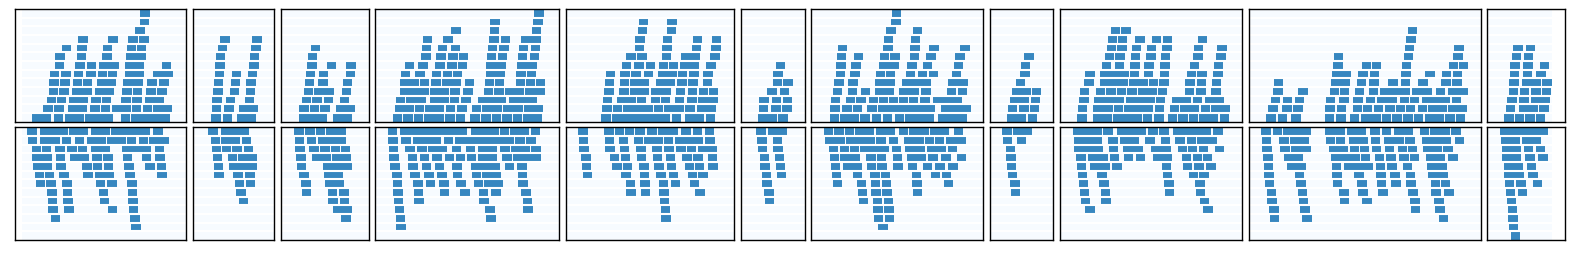

In [92]:
tx = siglec_11.loc[siglec_11['Gene']==gene, 'Transcript ID'].values[0]
protein = siglec_11.loc[siglec_11['Gene']==gene, 'Protein'].values[0]

#--------check that it's the correct transcript and get the WT transcript sequence-------
start_end_cds_20, start_end_cds, chrom, strand = tx_processor(tx)

bounds = np.asarray(start_end_cds)- (min(proto_df['start'])-20)
bounds[:,1] =bounds[:,1]+40
bounds[:,0] =bounds[:,0]-40

wr = [i[1]-i[0] for i in bounds]
wr = [i/max(wr) for i in wr]

#plus, minus = proto_viz('num_pegRNAs')

#max_pegs = max(proto_df['num_pegRNAs'])
max_pegs = 1.5

fig, ax = plt.subplots(2,len(bounds), figsize=(20,3), width_ratios = wr)
#cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i, val in enumerate(bounds):
    g = sns.heatmap(plus[::-1], cmap='Blues', ax=ax[0][i], vmax = max_pegs, yticklabels=False, xticklabels=False, cbar=False)
    ax[0][i].hlines(list(range(len(plus)))[1:], *ax[0][i].get_xlim(), color='white')
    ax[0][i].set_xlim(val[0], val[1])

    g2 = sns.heatmap(minus, cmap='Blues', ax=ax[1][i], vmax=max_pegs, cbar=False, yticklabels=False,xticklabels=False, cbar_ax=None)
    ax[1][i].set_xlim(val[0], val[1])
    ax[1][i].hlines(list(range(len(minus)))[1:], *ax[1][i].get_xlim(), color='white')

    for _, spine in g.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
    for _, spine in g2.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)

#ax[0][5].set_title('Number of pegRNAs per protospacer', fontsize=15)
plt.subplots_adjust(wspace=.05, hspace=.05)
#fig.savefig(f'figures/tiling_{gene}.png', dpi=400)

In [124]:
def matrix_mut_viz(gene, cdks, e, save_name, save=False):

    a = cdks.loc[cdks['Gene']==gene, 'Protein'].values[0]
    len_prot = len(a)
    #also generate a mutation matrix (see p53 stuff for visualizaiton)

    uniq_aa = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y','*',]

    print(gene)
    dict_aa = dict(zip(uniq_aa,list(range(21))))
    mat = np.zeros((21,len_prot))

    
    e = e[(e['HGVSp']!= 'WT') & (e['Complex']==False)]

    for i, val in e.iterrows():
        m = str(val['MUT_AA'])
        m_idx = dict_aa[m]

        codon = int(val['Codon'])-1

        mat[m_idx][codon]+=1

    #and plotting the results
    fig, ax = plt.subplots(2,1, figsize=(12,7), height_ratios=[3, 10,], sharex=True)
    g = sns.heatmap(mat, cmap='Purples', cbar=False, ax=ax[1], vmax=2)


    #ax.set_yticks(range(1,22), rotation=0)
    #ax[1].set_yticks(range(len(uniq_aa)), rotation=0)
    totals = np.sum(mat,axis=0) 
    ax[0].bar(range(len_prot), totals, color='tab:purple', edgecolor='tab:purple')
    #ax[0].plot(range(393), totals)

    ax[1].set_xticks(np.arange(0, len_prot, 50))
    ax[1].set_xticklabels(np.arange(0, len_prot, 50)+1, rotation=0)


    ax[1].set_yticklabels(uniq_aa, rotation=0)
    ax[0].tick_params(axis='both', which='major', labelsize=13)


    ax[1].tick_params(axis='both', which='major', labelsize=13)
    ax[1].set_xlabel('Codon', fontsize=14)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)
    ax[0].set_ylabel('No. of gRNAs', fontsize=14)
    #ax[0].set_yticks([0,100,200,300], fontsize=14)
    #ax[0].set_yticklabels(['',100,200,300], fontsize=14)

    #fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    fig.subplots_adjust(hspace=0.05)
    ax[0].set_title('Combined ABE and CBE Predicted Edits', fontsize=16)

    if save==True:
        fig.savefig(f'figures/{save_name}.pdf')

Siglec-11


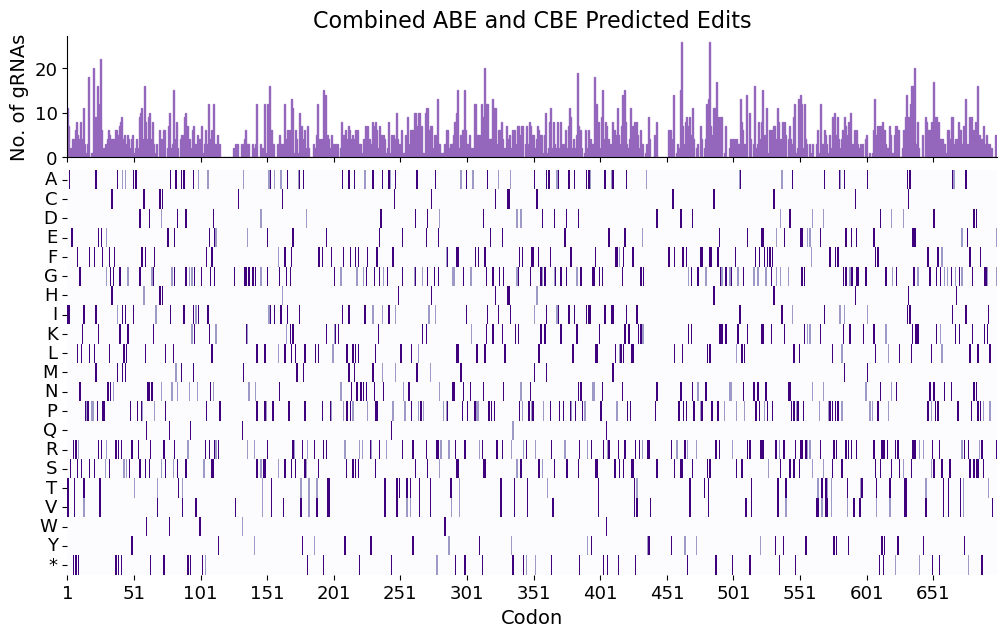

In [116]:
matrix_mut_viz('Siglec-11', siglec_11, siglec_11_edits_filtered, 'CBE_ABE_combined',save=True)

In [117]:
ABE = siglec_11_edits_filtered[siglec_11_edits_filtered['Editor']=='ABE']
CBE = siglec_11_edits_filtered[siglec_11_edits_filtered['Editor']=='CBE']

Siglec-11


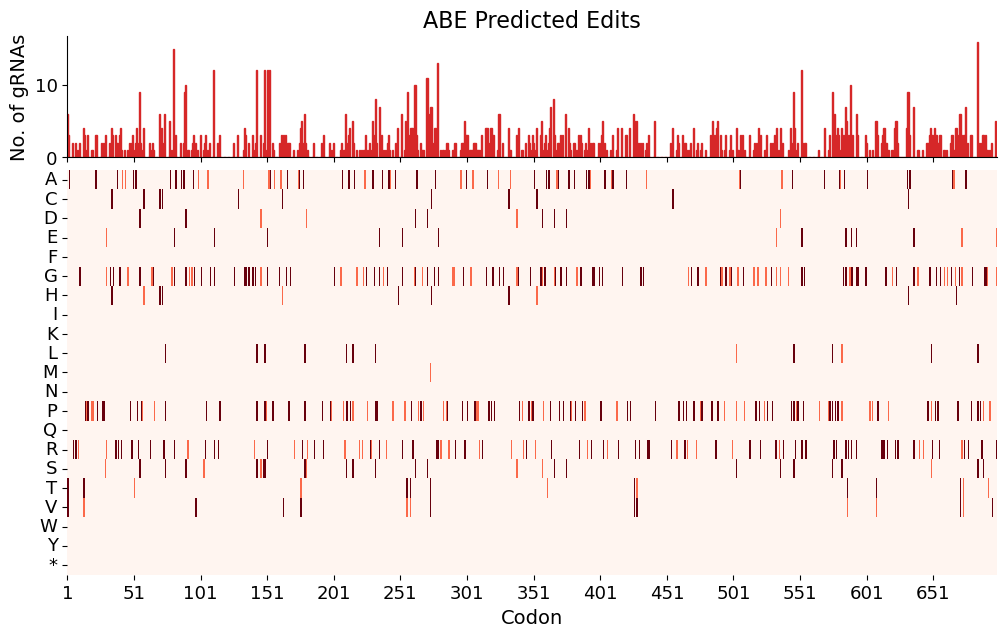

In [125]:
matrix_mut_viz('Siglec-11', siglec_11, ABE, 'ABE_predicted',save=True)

Siglec-11


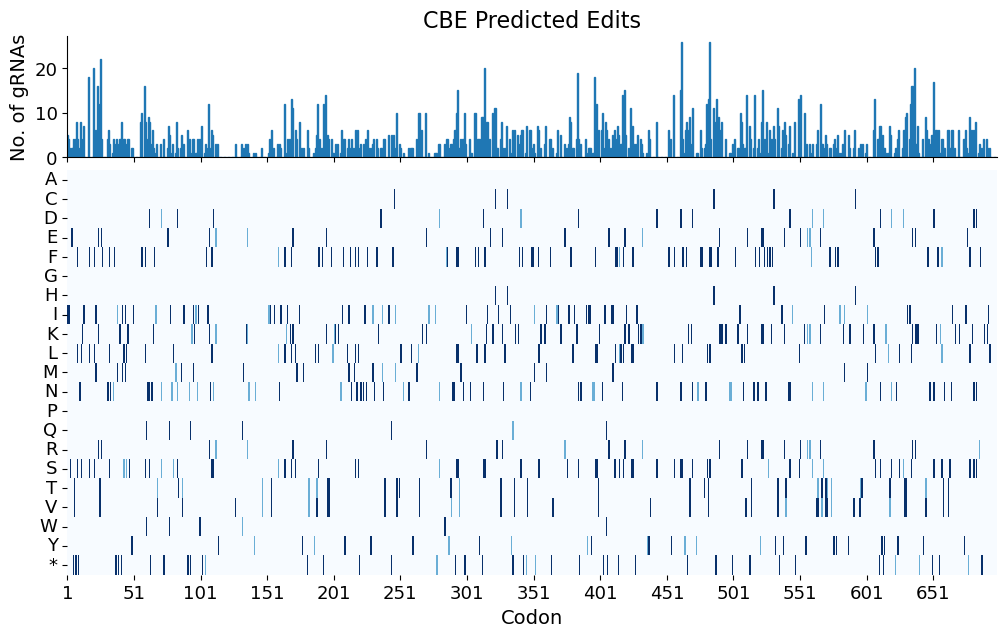

In [123]:
matrix_mut_viz('Siglec-11', siglec_11, CBE, 'CBE_predicted',save=True)

# fraction that can be modeled

In [133]:
both_list = []
abe_list = []
cbe_list = []

e = siglec_11_edits_filtered
e = e[(e['HGVSp']!= 'WT') & (e['Complex']==False)]
both = len(np.unique(e['Codon']))
abe_subset = len(np.unique(e[e['Editor']=='ABE']['Codon']))
cbe_subset = len(np.unique(e[e['Editor']=='CBE']['Codon']))

both_list.append(both)
abe_list.append(abe_subset)
cbe_list.append(cbe_subset)

#len(np.unique(cdk7[(cdk7['HGVSp']!= 'WT') & (cdk7['Complex']==False)]['Codon']))

col_names = ['Gene', 'ABE', 'CBE', 'Both']
cols = [edit_dict.keys(), abe_list, cbe_list, both_list]
df = pd.DataFrame(dict(zip(col_names, cols)))
df['Protein_length'] = len(siglec_11['Protein'].values[0])

df['ABE_frac'] = 100*df['ABE']/df['Protein_length']
df['CBE_frac'] = 100*df['CBE']/df['Protein_length']
df['Both_frac'] = 100*df['Both']/df['Protein_length']

df

,Gene,ABE,CBE,Both,Protein_length,ABE_frac,CBE_frac,Both_frac
0,Siglec-11,421,463,615,698,60.315186,66.332378,88.108883


In [134]:
col_names = ['Gene', 'Editor', 'Fraction Coverage']
cols1 = [list(df['Gene']), 'ABE', list(df['ABE_frac'])]
cols2 = [list(df['Gene']), 'CBE', list(df['CBE_frac'])]
cols3 = [list(df['Gene']), 'Both', list(df['Both_frac'])]

abe = pd.DataFrame(dict(zip(col_names, cols1)))
cbe = pd.DataFrame(dict(zip(col_names, cols2)))
both = pd.DataFrame(dict(zip(col_names, cols3)))

plotting_df = pd.concat((abe, cbe, both))
plotting_df

,Gene,Editor,Fraction Coverage
0,Siglec-11,ABE,60.315186
0,Siglec-11,CBE,66.332378
0,Siglec-11,Both,88.108883


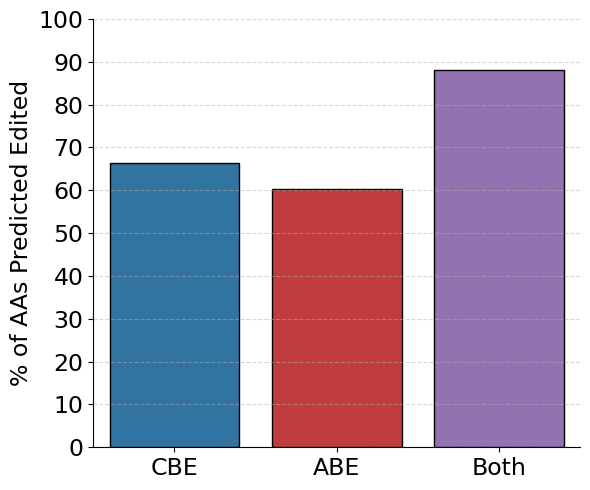

In [160]:
fig, ax = plt.subplots(figsize=(6,5))

sns.barplot(data = plotting_df, x='Editor', y= 'Fraction Coverage', linewidth=1, edgecolor='black',  order = ['CBE', 'ABE', 'Both'], palette=['tab:blue', 'tab:red', 'tab:purple'])
ax.tick_params(axis='both', which='major', labelsize=17)


ax.set_ylabel('% of AAs Predicted Edited', fontsize=17)
ax.set_xlabel('')
ax.spines[['right', 'top']].set_visible(False)
#ax.legend(fontsize=15, loc='lower right')
ax.set_ylim(0,100)
ax.set_yticks([0,10,20,30,40,50,60,70,80,90,100]);
ax.grid(axis='y', linestyle='dashed', alpha=.5)

fig.tight_layout()
fig.savefig('figures/predicted_edit.pdf')

# Looking at specific residues

In [147]:
np.unique(combined_library_filtered['classification'], return_counts=True)

(array(['intron', 'non-targeting control', 'targeting'], dtype=object),
 array([  35,   72, 1340]))

In [148]:
combined_library_filtered

,gRNA_id,Gene,protospacer,proto_G+19,chrom,exon,proto_start,proto_end,PAM,PAM_start,...,CDS_hit,ABE_amenable,CBE_amenable,classification,nearest_exon_distance,Pool,Hamming_BC,gRNA_oligo,RE_sites,gRNA_id_OLD
0,gRNA_Siglec-11_targ_1,Siglec-11,CTTCACTTTGGAACCATCCC,GTTCACTTTGGAACCATCCC,19.0,11,49949968.0,49949987.0,TG,49949988.0,...,True,True,True,targeting,NaN,F1-R1,CACATACGCACTA,AGGCACTTGCTCGTACGACGAGCGTACACGTCTCACACCGTTCACT...,2,gRNA_1
1,gRNA_Siglec-11_targ_2,Siglec-11,CTGACATCTCCCTCTCCAAT,GTGACATCTCCCTCTCCAAT,19.0,11,49949987.0,49950006.0,TG,49950007.0,...,True,True,True,targeting,NaN,F1-R1,CCTATACCCGAAT,AGGCACTTGCTCGTACGACGAGCGTACACGTCTCACACCGTGACAT...,2,gRNA_2
2,gRNA_Siglec-11_targ_3,Siglec-11,ACATCTCCCTCTCCAATTGA,GCATCTCCCTCTCCAATTGA,19.0,11,49949990.0,49950009.0,AG,49950010.0,...,True,False,True,targeting,NaN,F1-R1,TATACAATTCGCA,AGGCACTTGCTCGTACGACGAGCGTACACGTCTCACACCGCATCTC...,2,gRNA_3
3,gRNA_Siglec-11_targ_4,Siglec-11,CCTCTCCAATTGAAGCCCAA,GCTCTCCAATTGAAGCCCAA,19.0,11,49949997.0,49950016.0,AG,49950017.0,...,True,True,True,targeting,NaN,F1-R1,CCGGAGTAGGTCC,AGGCACTTGCTCGTACGACGAGCGTACACGTCTCACACCGCTCTCC...,2,gRNA_4
4,gRNA_Siglec-11_targ_5,Siglec-11,TCCAATTGAAGCCCAAAGCC,GCCAATTGAAGCCCAAAGCC,19.0,11,49950001.0,49950020.0,TG,49950021.0,...,True,True,False,targeting,NaN,F1-R1,ATTGCAAGGGCCC,AGGCACTTGCTCGTACGACGAGCGTACACGTCTCACACCGCCAATT...,2,gRNA_5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1442,gRNA_nt_1443,NaN,GTCTGGCTTGACACGACCGTT,GCTGGCTTGACACGACCGTT,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,non-targeting control,NaN,F1-R1,GCCGAATGGTGTG,AGGCACTTGCTCGTACGACGAGCGTACACGTCTCACACCGCTGGCT...,2,NaN
1443,gRNA_nt_1444,NaN,GCGCTAGGTCCGGTAAGTGCG,GGCTAGGTCCGGTAAGTGCG,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,non-targeting control,NaN,F1-R1,AATTCTATGAGCA,AGGCACTTGCTCGTACGACGAGCGTACACGTCTCACACCGGCTAGG...,2,NaN
1444,gRNA_nt_1445,NaN,GAGCACGTAATGTCCGTGGAT,GGCACGTAATGTCCGTGGAT,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,non-targeting control,NaN,F1-R1,TTGAGGCTGCTAT,AGGCACTTGCTCGTACGACGAGCGTACACGTCTCACACCGGCACGT...,2,NaN
1445,gRNA_nt_1446,NaN,GAAGGCGCGCGAATGTGGCAG,GAGGCGCGCGAATGTGGCAG,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,non-targeting control,NaN,F1-R1,AGGCGTCTACTCA,AGGCACTTGCTCGTACGACGAGCGTACACGTCTCACACCGAGGCGC...,2,NaN


In [153]:
#Arg40, Arg123, Glu126, Ala127, and Trp128

codons = [40, 123, 126, 127, 128]

siglec_11_edits_filtered[siglec_11_edits_filtered['Codon'].isin(codons)][['gRNA_id', 'ideal_window', 'edit', 'Editor', 'HGVSp', 'Codon']]

,gRNA_id,ideal_window,edit,Editor,HGVSp,Codon
1772,gRNA_Siglec-11_targ_643,CCTCT,CTTCT,CBE,R40K,40.0
1774,gRNA_Siglec-11_targ_643,CCTCT,TTTCT,CBE,R40K,40.0
1776,gRNA_Siglec-11_targ_643,CCTCT,CTTTT,CBE,R40K,40.0
1777,gRNA_Siglec-11_targ_643,CCTCT,TTTTT,CBE,R40K,40.0
752,gRNA_Siglec-11_targ_1225,AGGCA,GGGCA,ABE,E126G,126.0
754,gRNA_Siglec-11_targ_1225,AGGCA,GGGCG,ABE,E126G,126.0
922,gRNA_Siglec-11_targ_1292,AGGCA,GGGCA,ABE,R40G,40.0
925,gRNA_Siglec-11_targ_1293,GAGGC,GGGGC,ABE,R40G,40.0
927,gRNA_Siglec-11_targ_1294,GCAGA,GCAGG,ABE,R40G,40.0
1689,gRNA_Siglec-11_targ_1223,GCATG,GTATG,CBE,A127V,127.0


In [152]:
siglec_11_edits_filtered.columns

Index(['gRNA_id', 'edit', 'Editor', 'protospacer', 'exon', 'proto_start',
       'proto_end', 'PAM', 'PAM_start', 'PAM_end', 'ideal_start', 'ideal_end',
       'ideal_window', 'strand', 'CDS_hit', 'ABE_amenable', 'CBE_amenable',
       'HGVSp', 'potential_splice', 'Complex', 'MUT_AA', 'WT_AA', 'Codon',
       'sensor_wt', 'sensor_alt', 'Gene', 'gRNA_id_OLD'],
      dtype='object')

In [155]:
siglec_11_edits_filtered

,gRNA_id,edit,Editor,protospacer,exon,proto_start,proto_end,PAM,PAM_start,PAM_end,...,HGVSp,potential_splice,Complex,MUT_AA,WT_AA,Codon,sensor_wt,sensor_alt,Gene,gRNA_id_OLD
0,gRNA_Siglec-11_targ_1,CGCTT,ABE,CTTCACTTTGGAACCATCCC,11,49949968,49949987,TG,49949988,49949989,...,WT,True,False,None,None,NaN,AGGGAGATGTCAGGGATGGTTCCAAAGTGAAGAGGTCTCCAT,AGGGAGATGTCAGGGATGGTTCCAAAGCGAAGAGGTCTCCAT,Siglec-11,gRNA_1
1,gRNA_Siglec-11_targ_2,GCATC,ABE,CTGACATCTCCCTCTCCAAT,11,49949987,49950006,TG,49950007,49950008,...,S693P,False,False,P,S,693.0,CTTTGGGCTTCAATTGGAGAGGGAGATGTCAGGGATGGTTCC,CTTTGGGCTTCAATTGGAGAGGGAGATGCCAGGGATGGTTCC,Siglec-11,gRNA_2
2,gRNA_Siglec-11_targ_2,ACGTC,ABE,CTGACATCTCCCTCTCCAAT,11,49949987,49950006,TG,49950007,49950008,...,M692T,False,False,T,M,692.0,CTTTGGGCTTCAATTGGAGAGGGAGATGTCAGGGATGGTTCC,CTTTGGGCTTCAATTGGAGAGGGAGACGTCAGGGATGGTTCC,Siglec-11,gRNA_2
3,gRNA_Siglec-11_targ_2,GCGTC,ABE,CTGACATCTCCCTCTCCAAT,11,49949987,49950006,TG,49950007,49950008,...,M692T_S693P,False,True,None,None,NaN,CTTTGGGCTTCAATTGGAGAGGGAGATGTCAGGGATGGTTCC,CTTTGGGCTTCAATTGGAGAGGGAGACGCCAGGGATGGTTCC,Siglec-11,gRNA_2
4,gRNA_Siglec-11_targ_4,CTCCG,ABE,CCTCTCCAATTGAAGCCCAA,11,49949997,49950016,AG,49950017,49950018,...,L688S,False,False,S,L,688.0,GGGGCCCAGGCTTTGGGCTTCAATTGGAGAGGGAGATGTCAG,GGGGCCCAGGCTTTGGGCTTCAATCGGAGAGGGAGATGTCAG,Siglec-11,gRNA_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2055,gRNA_Siglec-11_targ_1338,GGTTT,CBE,GATGGTCCCGGGACAGGCCC,1,49961082,49961063,AG,49961061,49961060,...,P3S,False,False,S,P,3.0,GGCTCTGGGGCTGGGCCTGTCCCGGGACCATCTGGCTTCTGG,GGCTCTGGGGCTGGGCCTGTCCCGAAACCATCTGGCTTCTGG,Siglec-11,gRNA_1404
2056,gRNA_Siglec-11_targ_1339,TAGAT,CBE,AGCCAGATGGTCCCGGGACA,1,49961087,49961068,GG,49961066,49961065,...,WT,True,False,None,None,NaN,TGGGGCTGGGCCTGTCCCGGGACCATCTGGCTTCTGGGCCGG,TGGGGCTGGGCCTGTCCCGGGACCATCTAGCTTCTGGGCCGG,Siglec-11,gRNA_1405
2057,gRNA_Siglec-11_targ_1340,TCAGA,CBE,AAGCCAGATGGTCCCGGGAC,1,49961088,49961069,AG,49961067,49961066,...,WT,True,False,None,None,NaN,GGGGCTGGGCCTGTCCCGGGACCATCTGGCTTCTGGGCCGGC,GGGGCTGGGCCTGTCCCGGGACCATCTGACTTCTGGGCCGGC,Siglec-11,gRNA_1406
2058,gRNA_Siglec-11_targ_1340,CTAGA,CBE,AAGCCAGATGGTCCCGGGAC,1,49961088,49961069,AG,49961067,49961066,...,WT,True,False,None,None,NaN,GGGGCTGGGCCTGTCCCGGGACCATCTGGCTTCTGGGCCGGC,GGGGCTGGGCCTGTCCCGGGACCATCTAGCTTCTGGGCCGGC,Siglec-11,gRNA_1406
